# A5

In [37]:
# Standard Imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import Network as NN
import importlib
import mnist_loader

import copy
import random

# Q1: Electrophysiology Experiment

In [38]:
import lif

def MonkeyFixationSpikes(x, T, pop):
    """
    spike_times = MonkeyFixationSpikes(x, T, pop)

    Given the gaze direction, outputs the spiking activity of the monkey's
    neurons.

    Input:
      x is the monkey's gaze direction
      T is the duration of the fixation (in seconds)
      pop is a 6xN matrix of LIF parameters

    Output:
      spike_times is an list containing N arrays of time-stamps indicating
        when each neuron fired.  
    """
    dt = 0.001  # time-step size for simulations
    xts = x*np.ones(int(T/dt))
    sp, v = lif.Stim2Spikes(xts, dt, pop, interp=True)
    return sp

In [39]:
#=====================
# CHOOSE A MONKEY
# The monkey's are numbered 0, 1, 2, 3, and 4.
# This will read in the LIF parameters for the monkey's neurons
# as well as the spiking trains for the unknown sequence.
#=====================
infile = open('monkey3.npz', 'rb')
varsin = np.load(infile)
pop = varsin['pop']   # parameters for population of neurons
Asp = varsin['Asp']   # spike trains for unknown sequence
N = len(pop[1])  # number of neurons

## (a) Behavioural Sampling Experiment

In [40]:
# Select a spread of stimulus values from 0 to 9. Choose at least 100 samples.
X = np.linspace(0, 9, 100)
A = []
for x in X:
    spike_times = MonkeyFixationSpikes(x, 0.4, pop)
    current_firing_rate = []
    for neuron_times in spike_times:
        # naive freq. calculation for smoother curves
        current_firing_rate.append((len(neuron_times)/0.4) if len(neuron_times) == 0 else (len(neuron_times)/neuron_times[-1]))
    A.append(current_firing_rate)
A = np.asarray(A) # A is 100 x 40

## (b) View Tuning Curves

Text(0.5, 1.0, 'Tuning Curves')

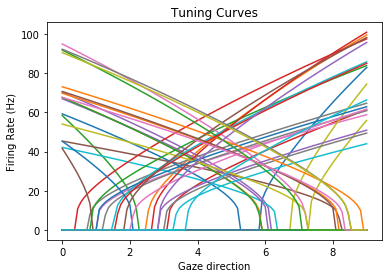

In [41]:
A_plot = A.T
for i in range(N):
    plt.plot(X, A_plot[i])
    
plt.xlabel('Gaze direction')
plt.ylabel('Firing Rate (Hz)')
plt.title('Tuning Curves')

## (c) Compute the Decoding Weights

In [42]:
# ***** YOUR CODE HERE *****
D = np.linalg.inv((A.T.dot(A))).dot(A.T).dot(X)

## (d) View Spike Raster of Unknown Sequence

Text(0, 0.5, 'Neurons')

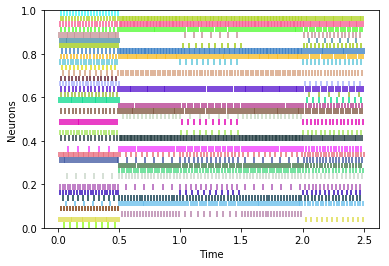

In [43]:
# ***** YOUR CODE HERE *****
lif.PlotSpikeRaster(Asp)
plt.xlabel("Time")
plt.ylabel("Neurons")

## (e) Decode the Unknown Code

In [44]:
# Spike trains for unknown sequence are stored in 'Asp'
# Asp is a list of arrays of spike trains, one array per neuron.

In [45]:
# Compute firing rates
# compute firing rates for each 2.5 seconds
A_test = []
for i in np.arange(0,2.5,0.5):
    A_test.append(lif.CountSpikes(Asp,i,i+0.5)/0.5)
A_test = np.asarray(A_test) # A is 5 x 40

In [46]:
# Decode unknown code
X_decoded = A_test.dot(D)

## (f) Display the Unknown Code

Text(0.5, 1.0, 'Decoded Code: 61213')

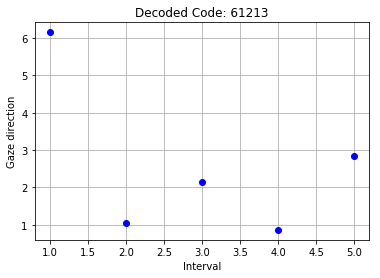

In [47]:
# ***** YOUR CODE HERE *****
plt.grid(True)
plt.plot(range(1,6), X_decoded, 'bo')
plt.ylabel("Gaze direction")
plt.xlabel("Interval")
plt.title("Decoded Code: 61213")

# Q2: LSTM

In [48]:
# You may include some Python code to help you.

## (a)

### (i)

In [49]:
# You can include some code, if you want.

# We implement the overall LSTM here, and for every question, we simply call these functions to
# realize how the values were changed
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-1*x))

# Setting initial wegiht matrices
W_f, W_o, W_i, W_C = np.array([0,8,0,0]), np.array([0,0,0,10]), np.array([0,0,9,0]), np.array([1,0,0,0])
b_i, b_C, b_f, b_o = -4.5, 0, -4, -5
# Setting initial states
h_t_minus_1, C_t_minus_1 = 0.05, -0.02

# A simple implementation of the FGSM
def feed_forward_LSTM(x_t):
    # Updating all states in the cell for one step
    v_t = np.append(h_t_minus_1, x_t)
    f_t = sigmoid(W_f.dot(v_t) + b_f)
    i_t = sigmoid(W_i.dot(v_t) + b_i)
    o_t = sigmoid(W_o.dot(v_t) + b_o)
    C_til_t = np.tanh(W_C.dot(v_t) + b_C)
    C_t = (f_t * C_t_minus_1) + (i_t * C_til_t)
    h_t = o_t * np.tanh(C_t)
    
    # Return c_t, h_t for computation
    return C_t, h_t

x_t = np.array([1,0,0])
print(feed_forward_LSTM(x_t))
# C_t = C_t-1
# h_t = 0 as o_t = 0 

(-0.01909138600117828, -0.00012776027875546997)


As we can see from above, approximately,
$$
\begin{align}
C_t = C_{t-1} \\
h_t = 0
\end{align}
$$
  
h_t is zero since the output gate (o_t) and the input gate is zero, and they 'switch off' the h_t and C from the current timestep.

### (ii)

In [50]:
x_t = np.array([0,1,0])
print(feed_forward_LSTM(x_t))
# C_t = C_til_t = h_t_minus_1
# h_t = 0

(0.049049760959058254, 0.00032801972156155)


As we can see from above, approximately,
$$
\begin{align}
C_t = h_{t-1} \\
h_t = 0
\end{align}
$$
  
h_t is 0 due to the same reason as above, and the C_t = h_{t-1} because only that component is activated on multiplication with W_c

### (iii)

In [51]:
x_t = np.array([1,0,1])
print(feed_forward_LSTM(x_t))
# C_t = C_t_minus_1 as i_t = 0
# h_t = C_t_minus_1

(-0.01909138600117828, -0.018961306577925104)


As we can see from above, approximately,
$$
\begin{align}
C_t = C_{t-1} \\
h_t = C_{t-1}
\end{align}
$$
  
C_t equals C_{t-1} as i_t=0 and h_t=C_{t-1} through the activation of the output gate.

## (b)

In [52]:
# [1,1,0] as the first one will 'open' the f_t gate and the second one will open the i_t gate, and C_til_t = h_t_minus_1
x_t = [1,1,0]
print(feed_forward_LSTM(x_t)) # Note: C_t = 0.05 - 0.02 = 0.03

(0.029769209357541914, 0.00019918204507686518)


[1,1,0] as the first one will 'open' the f_t gate and the second one will open the i_t gate, and C_til_t = h_t_minus_1 and the zero to ensure the output gate is closed

## (c)

In [53]:
# [0.5, 0.5, 1]
x_t = [0.5,0.5,1] #first 0.5 leads to 0.5*c_t_minus_1, second 0.5 leads to 0.5*h_t_minus_1, third one ensures output gate is open
print(feed_forward_LSTM(x_t)) # Note: C_t = (0.05 - 0.02)/2 = 0.03/2 = 0.015

(0.014979187478939988, 0.014877821284526208)


[0.5, 0.5, 1] as the first 2 0.5s provide for averaging (first 0.5 leads to 0.5*c_t_minus_1, second 0.5 leads to 0.5*h_t_minus_1) and the third one ensures output gate is open  

# Q3: Adversarial Inputs

## Load data, get trained network, etc.

In [54]:
# Load MNIST
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0])
train_out = np.array(train[1])

In [55]:
# You can create and train your own Network on MNIST.
# You can save it like this...
# net.Save('blah.npy')

In [56]:
# Or, you can load the pretrained Network object from the supplied file,
# like this...
net = NN.Network()
net.Load('MNIST_trained_784-100-100-10.npy')

In [57]:
print(net.lyr[-1].sigma)
print(net.lyr[-1].act_text)

<function Softmax at 0x1125b6ea0>
softmax


In [58]:
test_ac = NN.ClassificationAccuracy(net.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

train_ac = NN.ClassificationAccuracy(net.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

Testing Accuracy = 97.53%
Training Accuracy = 99.136%


In [59]:
#Extract 10 digits from MNIST classified correctly by the network
x_image = []
x_class = []
for i in range(0, 10):
    while True:
        j = random.randint(0, len(test[0]))
        if np.argmax(test[1][j]) == i:
            r = net.FeedForward([test[0][j]])
            if np.argmax(r) == i:
                x_image.append(test[0][j])
                x_class.append(test[1][j])
                break

## (a) GradientInput

In [60]:
def GradientInput(net, x, t):
    '''
        dEdx = Input_Gradient_Ascent(net, x, t)

        Computes dEdx for a network given input x and target t.
        The cost function is specified by the network.

        Inputs:
          net is the neural network
          x is the input that you want to perturb
          t is the corresponding true target vector (one-hot)
        
        Output:
          dEdx is a vector the same shape as x
    '''
    t = np.array(t)  # convert t to an array, in case it's not
                
    # Error gradient for top layer
    dEdz = net.TopGradient(t) 

    # Loop down through the layers
    for i in range(net.n_layers-2, -1, -1):
        pre = net.lyr[i]

        # If not the bottom layer,
        # Project error gradient down to layer below
        if i>0:
            dEdz = ( dEdz @ net.W[i].T ) * pre.sigma_z_p(pre.z)
    
    dEdx = dEdz @ net.W[0].T
    
    return dEdx.T

## (b) FGSM

In [61]:
def FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5, targ=False):
    '''
        x_adv = FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5)
        
        Performs the Fast Gradient Sign Method, perturbing each input until it
        is misclassified with the specified confidence, or reaches the maximum
        number of iterations.
        
        Inputs:
          net is the Network object
          x_input is a batch of inputs
          x_class is the corresponding one-hot class vectors
          ep is the perturbation step for the FGSM
          it_lim is the maximum number of iterations
          conf is the desired confidence for the misclassification
          targ is Boolean, indicating if the FGSM is targetted
             if targ is False, then x_class is considered to be the true
             class of the input, and FGSM will work to increase the cost
             if targ is True, then x_class is considered to be the target
             class for the perturbation, and FGSM will work to decrease the cost
        
        Output:
          x_adv is a batch of adversarial inputs, the same size as x_input
    '''
    x_adv = copy.deepcopy(x_input)
    for j in range(len(x_adv)):
        x_t = x_class[j][np.newaxis, :]
        true_class = np.argmax(x_class[j])
        for i in range(it_lim):
            x = x_adv[j][np.newaxis, :]
            r = net.FeedForward(x)[0]
            r_class = np.argmax(r)
            # check for confidence in each case
            if not targ and true_class != r_class and r[r_class] >= conf:
                break
            elif targ and true_class == r_class and r[r_class] >= conf:
                break
            grad = GradientInput(net, x, x_t)
            sign_grad = np.sign(grad)[:,0]
            if not targ:
                x_adv[j] += ep*sign_grad
            else:
                x_adv[j] -= ep*sign_grad
    
    return np.array(x_adv)

## (c) Untargetted Adversarial Perturbation

Digit 0 classified as 9 with classification value 0.987616
Digit 1 classified as 8 with classification value 0.996679
Digit 2 classified as 3 with classification value 0.941486
Digit 3 classified as 8 with classification value 0.999654
Digit 4 classified as 9 with classification value 0.932355
Digit 5 classified as 3 with classification value 0.999794
Digit 6 classified as 5 with classification value 0.999562
Digit 7 classified as 9 with classification value 0.999718
Digit 8 classified as 3 with classification value 0.950269
Digit 9 classified as 7 with classification value 0.989996


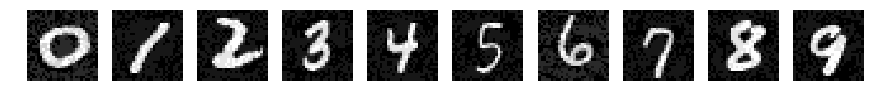

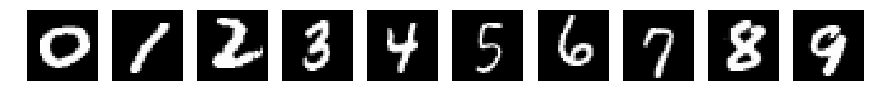

In [62]:
x_image, x_class = np.array(x_image), np.array(x_class)
x_image_c = copy.deepcopy(x_image)

x_adv = FGSM(net, x_image_c, x_class, ep=0.05)
plt.figure(figsize=[15,10])
for i in range(len(x_adv)):
    digit = np.argmax(x_class[i])
    x = x_adv[i][np.newaxis, :]
    r = net.FeedForward(x)[0]
    r_class = np.argmax(r)
    confidence = r[r_class]
    print("Digit %i classified as %i with classification value %f" %(digit, r_class, confidence))
    
for i in range(len(x_adv)):
    plt.subplot(2,10,i+1)
    plt.imshow(np.reshape(x_adv[i], [28,28]), cmap='gray'); plt.axis('off')
    
plt.figure(figsize=[15,10])
for i in range(len(x_image)):
    plt.subplot(2,10,i+1)
    plt.imshow(np.reshape(x_image[i], [28,28]), cmap='gray'); plt.axis('off')
    

## (d) Targetted Adversarial Perturbation

Digit 5 classified as 3 with classification value 0.990335
Digit 1 classified as 8 with classification value 0.981848
Digit 7 classified as 6 with classification value 0.881945


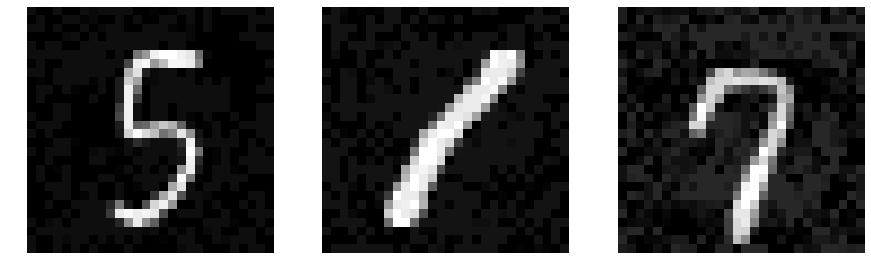

In [63]:
true_digits = np.array([x_class[5], x_class[1], x_class[7]])
true_images = np.array([x_image[5], x_image[1], x_image[7]])
# Get one hot encoding for every resulting digit
p_digits = np.array([x_class[3], x_class[8], x_class[6]])

# Perturb through FGSM:
x_result = FGSM(net, true_images, p_digits, ep=0.01, conf=0.8, targ=True)

# Checking the perturbations
for i in range(3):
    x = x_result[i][np.newaxis, :]
    r = net.FeedForward(x)[0]
    r_class = np.argmax(r)
    confidence = r[r_class]
    digit = np.argmax(true_digits[i])
    print("Digit %i classified as %i with classification value %f" %(digit, r_class, confidence))


plt.figure(figsize=[15,10])
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(np.reshape(x_result[i], [28,28]), cmap='gray'); plt.axis('off')
